
Examining file: session3_participant1.mat
Dataset: 7 trials × 17 gestures
Channels: 16 forearm + 12 wrist = 28 total
Recording: 10240 samples, 5.0s @ 2048 Hz


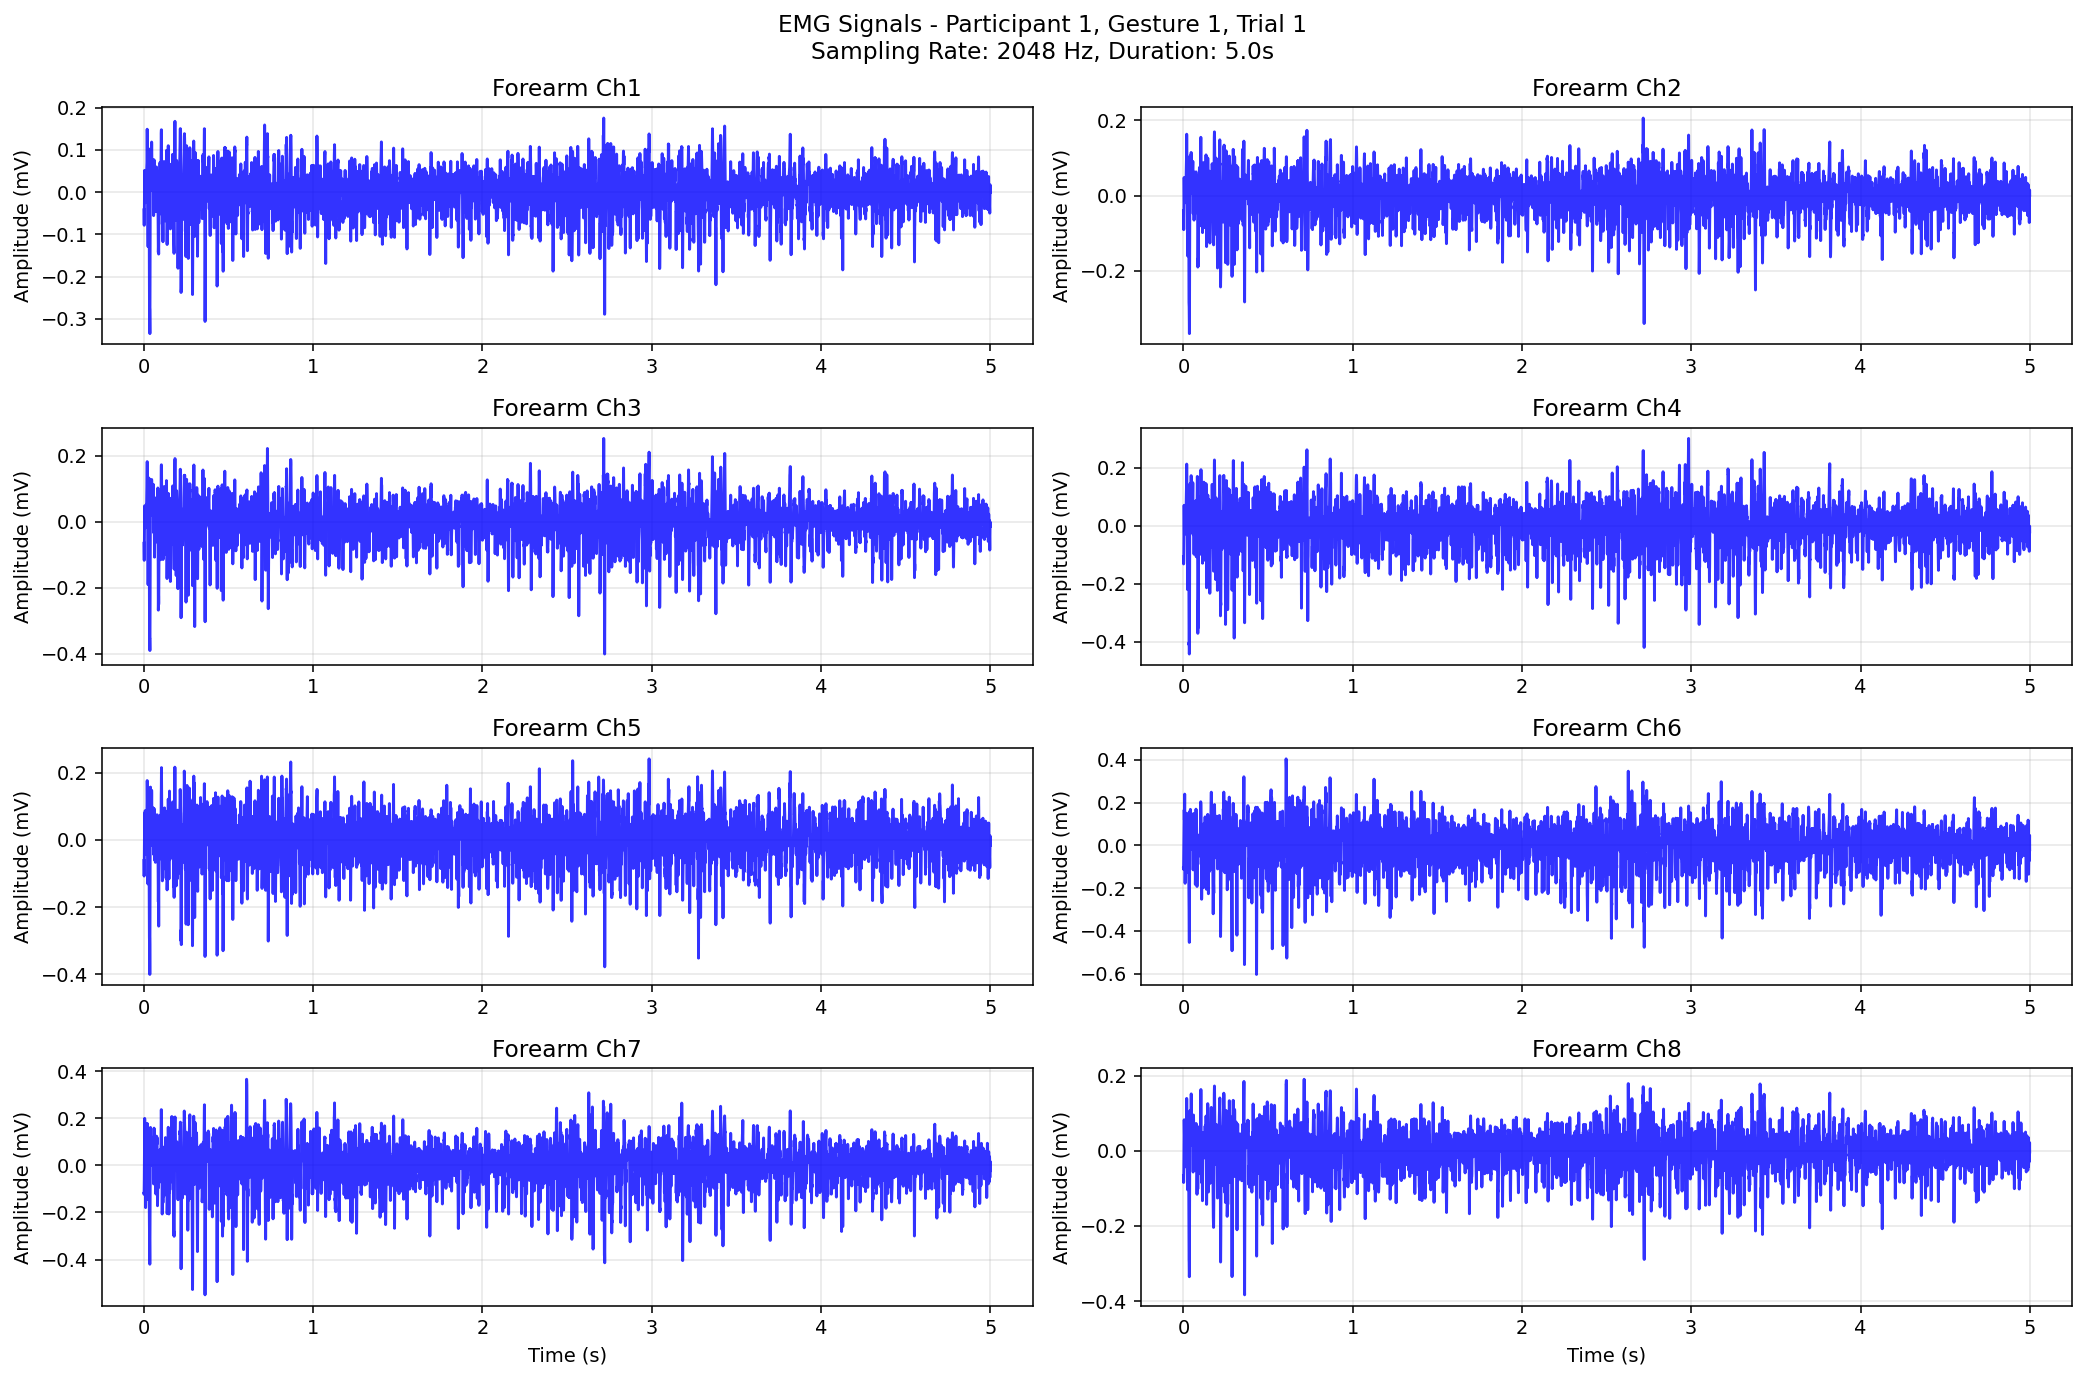

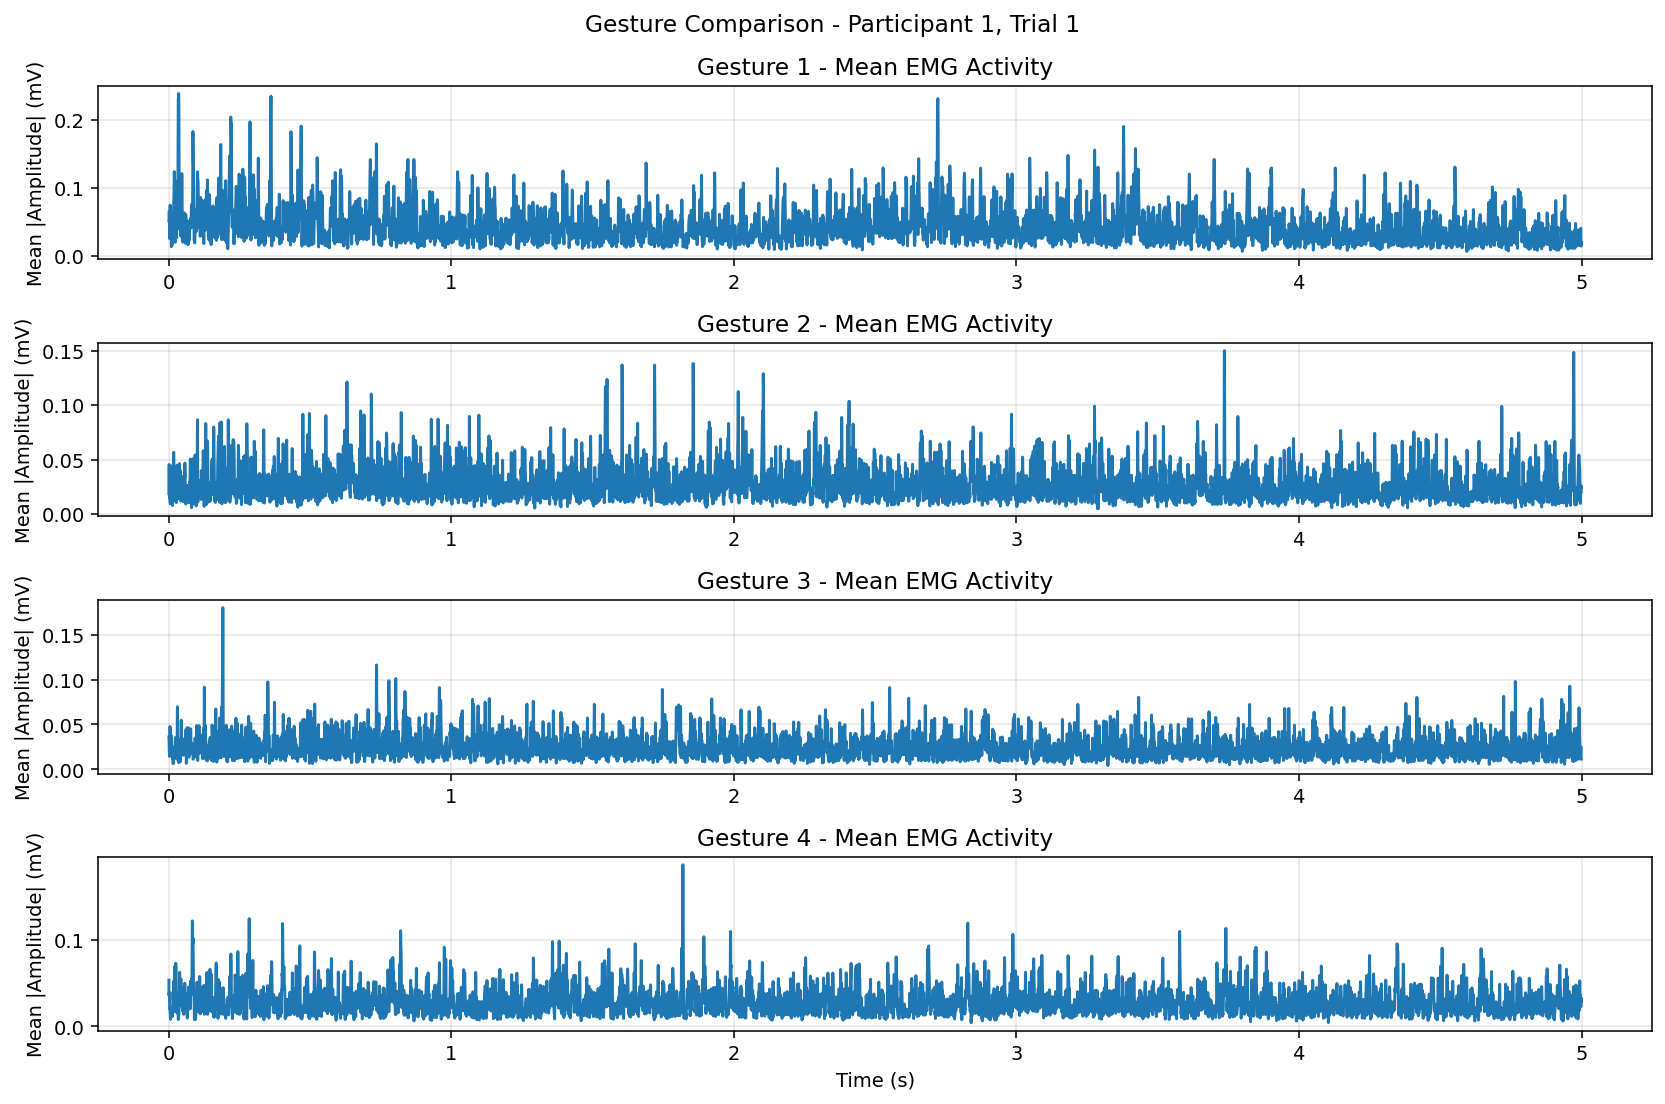

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from pathlib import Path
from natsort import natsorted

data_path = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session3_converted")
mat_files = natsorted(list(data_path.glob("*.mat"))) # use natsorted to sort files as 1, 2, 3, ... instead of 1, 10, 2, 20, 3,...

# Load and inspect a sample .mat file
if mat_files:
    sample_file = mat_files[0]
    print(f"\nExamining file: {sample_file.name}")
    participant_file = sio.loadmat(sample_file) # load .mat file with scipy


def calculate_sampling_rate(emg_data, expected_duration=5.0):
    """Calculate sampling rate from data shape."""
    n_samples = emg_data.shape[0]
    return n_samples / expected_duration

def plot_emg_overview(participant_file, participant_id, gesture_idx=0, trial_idx=0, n_channels=8):
    """Create comprehensive EMG visualization with calculated parameters."""
    
    # Extract data
    forearm_emg = participant_file['DATA_FOREARM'][trial_idx, gesture_idx]
    wrist_emg = participant_file['DATA_WRIST'][trial_idx, gesture_idx]
    
    # Calculate actual sampling rate instead of hardcoding
    sampling_rate = calculate_sampling_rate(forearm_emg)
    
    # Combine data
    all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
    time_axis = np.arange(all_emg.shape[0]) / sampling_rate
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_channels//2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot channels with clear labeling
    for i in range(min(n_channels, all_emg.shape[1])):
        row, col = divmod(i, 2)
        
        # Determine channel source
        if i < forearm_emg.shape[1]:
            channel_label = f'Forearm Ch{i+1}'
            color = 'blue'
        else:
            channel_label = f'Wrist Ch{i-forearm_emg.shape[1]+1}'
            color = 'red'
            
        axes[i].plot(time_axis, all_emg[:, i], color=color, alpha=0.8)
        axes[i].set_title(channel_label)
        axes[i].set_ylabel('Amplitude (mV)')
        axes[i].grid(True, alpha=0.3)
        
        if i >= n_channels - 2:  # Bottom row
            axes[i].set_xlabel('Time (s)')
    
    plt.suptitle(f'EMG Signals - Participant {participant_id}, Gesture {gesture_idx+1}, Trial {trial_idx+1}\n'
                f'Sampling Rate: {sampling_rate:.0f} Hz, Duration: {time_axis[-1]:.1f}s', y=0.98)
    plt.tight_layout()
    return fig, sampling_rate

def compare_gestures(participant_file, participant_id, gestures=[0, 1, 2], trial_idx=0):
    """Compare the same trial across different gestures."""
    
    fig, axes = plt.subplots(len(gestures), 1, figsize=(12, 8))
    if len(gestures) == 1:
        axes = [axes]
    
    for i, gesture_idx in enumerate(gestures):
        forearm_emg = participant_file['DATA_FOREARM'][trial_idx, gesture_idx]
        wrist_emg = participant_file['DATA_WRIST'][trial_idx, gesture_idx]
        all_emg = np.concatenate([forearm_emg, wrist_emg], axis=1)
        
        sampling_rate = calculate_sampling_rate(forearm_emg)
        time_axis = np.arange(all_emg.shape[0]) / sampling_rate
        
        # Plot mean activity across all channels
        mean_activity = np.abs(all_emg).mean(axis=1)
        axes[i].plot(time_axis, mean_activity)
        axes[i].set_title(f'Gesture {gesture_idx+1} - Mean EMG Activity')
        axes[i].set_ylabel('Mean |Amplitude| (mV)')
        axes[i].grid(True, alpha=0.3)
        
        if i == len(gestures) - 1:
            axes[i].set_xlabel('Time (s)')
    
    plt.suptitle(f'Gesture Comparison - Participant {participant_id}, Trial {trial_idx+1}')
    plt.tight_layout()
    return fig

def get_data_summary(participant_file):
    """Get comprehensive data summary without hardcoding."""
    forearm_shape = participant_file['DATA_FOREARM'].shape
    wrist_shape = participant_file['DATA_WRIST'].shape

    # Get sample recording info
    sample_forearm = participant_file['DATA_FOREARM'][0, 0]
    sample_wrist = participant_file['DATA_WRIST'][0, 0]

    sampling_rate = calculate_sampling_rate(sample_forearm)
    duration = sample_forearm.shape[0] / sampling_rate
    
    summary = {
        'trials': forearm_shape[0],
        'gestures': forearm_shape[1], 
        'forearm_channels': sample_forearm.shape[1],
        'wrist_channels': sample_wrist.shape[1],
        'total_channels': sample_forearm.shape[1] + sample_wrist.shape[1],
        'samples_per_recording': sample_forearm.shape[0],
        'sampling_rate': sampling_rate,
        'duration': duration
    }
    
    return summary

# Usage example (replace with your loaded data)
summary = get_data_summary(participant_file)
print(f"Dataset: {summary['trials']} trials × {summary['gestures']} gestures")
print(f"Channels: {summary['forearm_channels']} forearm + {summary['wrist_channels']} wrist = {summary['total_channels']} total")
print(f"Recording: {summary['samples_per_recording']} samples, {summary['duration']:.1f}s @ {summary['sampling_rate']:.0f} Hz")

fig1, sr = plot_emg_overview(participant_file, participant_id=1, gesture_idx=0, trial_idx=0)
fig2 = compare_gestures(participant_file, participant_id=1, gestures=[0, 1, 2, 3])
plt.show()

In [9]:
# --- Common imports & helpers (run once at the top of your notebook) ---
from pathlib import Path
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.dpi'] = 140

# ---- IO helpers ----
def load_grabmyo_participant(mat_path):
    """Return (forearm_obj, wrist_obj) as MATLAB cell-like object arrays: shape (trials=7, gestures=17)."""
    D = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    fore = D.get('DATA_FOREARM')
    wrist = D.get('DATA_WRIST')
    assert fore is not None and wrist is not None, "Expected DATA_FOREARM and DATA_WRIST in the .mat file."
    return fore, wrist

def get_trial(fore_obj, wrist_obj, trial_idx, gesture_idx, concat=True):
    """
    Returns arrays:
        Xf: (time, ch_f) forearm
        Xw: (time, ch_w) wrist
        X : (time, ch_f + ch_w) if concat==True
    """
    Xf = fore_obj[trial_idx, gesture_idx]
    Xw = wrist_obj[trial_idx, gesture_idx]
    # Ensure time x channels
    if Xf.shape[0] < Xf.shape[1]: Xf = Xf.T
    if Xw.shape[0] < Xw.shape[1]: Xw = Xw.T
    X = np.concatenate([Xf, Xw], axis=1) if concat else None
    return Xf, Xw, X

# ---- Filter/envelope helpers ----
def butter_bandpass(x, fs, lo=20, hi=450, order=4):
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)

def butter_lowpass(x, fs, cutoff=10, order=4):
    b,a = butter(order, cutoff/(fs/2), btype='low')
    return filtfilt(b, a, x, axis=0)

def emg_envelope(x, fs, bp_lo=20, bp_hi=450, env_lp=10):
    x_bp = butter_bandpass(x, fs, bp_lo, bp_hi)
    x_env = butter_lowpass(np.abs(x_bp), fs, env_lp)
    return x_bp, x_env

def clipping_metrics(x, fs, edge_frac=0.005, flat_ms=5):
    """Return %samples near extremes and number of flat runs at extremes (>= flat_ms)."""
    x = np.asarray(x)
    xmin, xmax = np.min(x), np.max(x)
    span = xmax - xmin if xmax > xmin else 1.0
    tol = edge_frac * span
    near_min = np.sum(x <= xmin + tol)
    near_max = np.sum(x >= xmax - tol)
    pct_edge = 100.0 * (near_min + near_max) / x.size
    # flat-run detection
    L = max(1, int(flat_ms * 1e-3 * fs))
    flat_runs = 0
    for is_max in [False, True]:
        c = (x >= xmax - tol) if is_max else (x <= xmin + tol)
        run = 0
        for v in c:
            if v: run += 1
            else:
                if run >= L: flat_runs += 1
                run = 0
        if run >= L: flat_runs += 1
    return dict(pct_edge=pct_edge, flat_runs=flat_runs)

def channel_summary(X, fs):
    rows = []
    for ch in range(X.shape[1]):
        x = X[:, ch]
        clip = clipping_metrics(x, fs)
        rows.append(dict(
            channel=ch,
            min=float(np.min(x)),
            max=float(np.max(x)),
            rms=float(np.sqrt(np.mean(x**2))),
            pct_near_edge=clip['pct_edge'],
            flat_runs=clip['flat_runs'],
            has_nan=bool(np.isnan(x).any()),
            has_inf=bool(np.isinf(x).any())
        ))
    return pd.DataFrame(rows)

def quick_psd(x, fs):
    f, pxx = welch(x, fs=fs, nperseg=1024, noverlap=512, axis=0)
    return f, pxx


Time samples: 10240, FS=2048 Hz, duration ≈ 5.00 s, channels=28


,channel,min,max,rms,pct_near_edge,flat_runs,has_nan,has_inf
0,0,-0.331451,0.263375,0.047702,0.019531,0,False,False
1,1,-0.431693,0.326675,0.065772,0.019531,0,False,False
2,2,-0.557720,0.408292,0.071339,0.029297,0,False,False
3,3,-1.107005,0.634780,0.118433,0.029297,0,False,False
4,4,-0.883048,0.600060,0.102838,0.029297,0,False,False
5,5,-0.269824,0.340103,0.050659,0.019531,0,False,False
6,6,-0.294603,0.242875,0.061719,0.019531,0,False,False
7,7,-0.260334,0.240766,0.049355,0.019531,0,False,False
8,8,-0.350121,0.277514,0.048651,0.019531,0,False,False
9,9,-0.484015,0.372005,0.071700,0.019531,0,False,False


Any NaN: False | Any Inf: False
Clipping flags (any): False


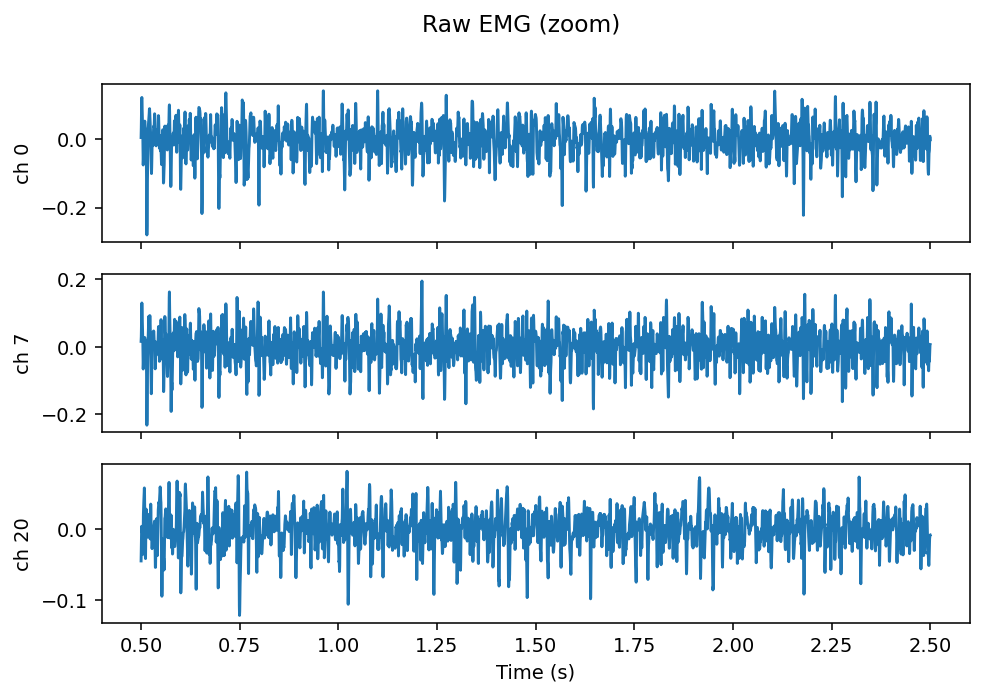

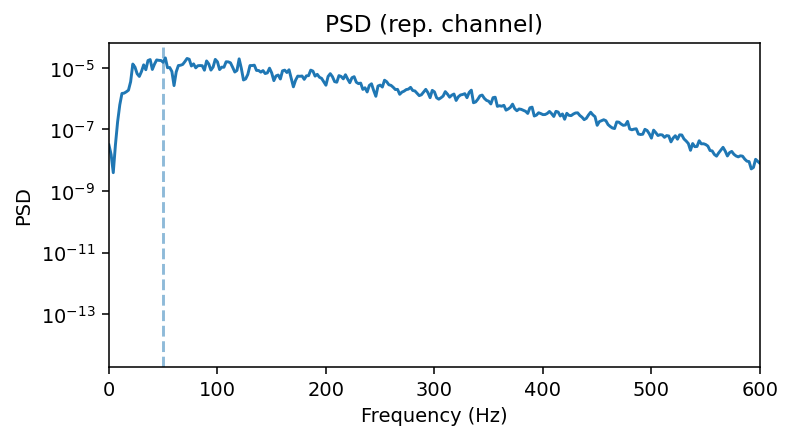

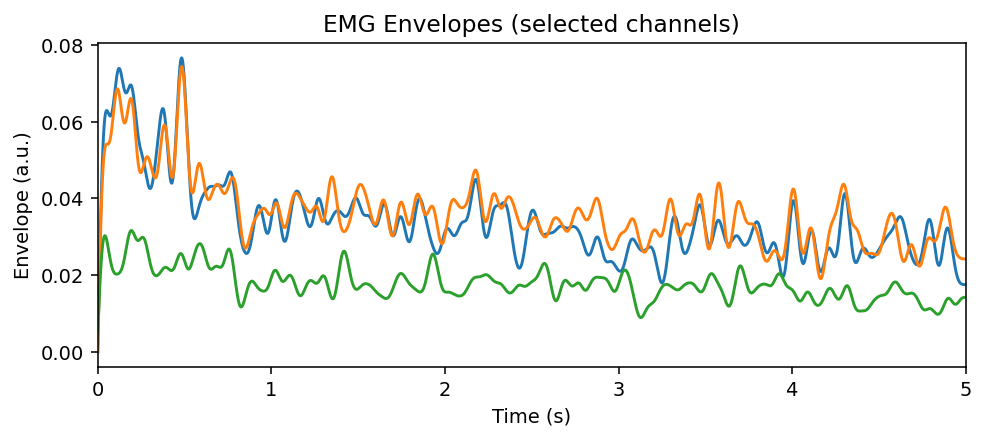

In [10]:
# Adjust to your actual file paths
PARTICIPANT_FILE = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted/session1_participant22.mat")
FS = 2048  # Hz (adjust if your metadata says otherwise)


# ---- STEP 1: Basic structure & integrity ----
fore, wrist = load_grabmyo_participant(PARTICIPANT_FILE)

trial_idx = 0   # 0..6
gesture_idx = 0 # 0..16  (adjust as needed)

Xf, Xw, X = get_trial(fore, wrist, trial_idx, gesture_idx, concat=True)
N = X.shape[0]
duration_s = N / FS
print(f"Time samples: {N}, FS={FS} Hz, duration ≈ {duration_s:.2f} s, channels={X.shape[1]}")

# Per-channel integrity summary
summ = channel_summary(X, FS)
display(summ.head(10))
print("Any NaN:", summ.has_nan.any(), "| Any Inf:", summ.has_inf.any())
print("Clipping flags (any):",
      (summ.pct_near_edge > 0.5).any() or (summ.flat_runs > 0).any())

# Choose 3 illustrative channels (two forearm + one wrist if possible)
ch_sel = [0, min(7, X.shape[1]-1), min(20, X.shape[1]-1)]

# Raw traces (2–3 s zoom)
t = np.arange(N) / FS
t0, t1 = 0.5, 2.5
mask = (t >= t0) & (t <= t1)

fig, ax = plt.subplots(len(ch_sel), 1, figsize=(8, 5), sharex=True)
for i, ch in enumerate(ch_sel):
    ax[i].plot(t[mask], X[mask, ch])
    ax[i].set_ylabel(f'ch {ch}')
ax[-1].set_xlabel('Time (s)')
fig.suptitle('Raw EMG (zoom)')
plt.show()

# PSD on one representative channel
f, pxx = quick_psd(X[:, ch_sel[0]], FS)
plt.figure(figsize=(6,3))
plt.semilogy(f, pxx)
plt.axvline(50, ls='--', alpha=0.5)
plt.xlim(0, 600)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('PSD (rep. channel)')
plt.show()

# Envelopes
X_bp, X_env = emg_envelope(X[:, ch_sel], FS)
plt.figure(figsize=(8,3))
plt.plot(t, X_env)
plt.xlim(0, duration_s)
plt.xlabel('Time (s)')
plt.ylabel('Envelope (a.u.)')
plt.title('EMG Envelopes (selected channels)')
plt.show()

In [ ]:
# ===== Step 1: Basic structure & integrity =====
from pathlib import Path
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.dpi'] = 140

# ------- paths & expected settings -------
PARTICIPANT_FILE = Path("/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted/session1_participant22.mat")
FS = 2048  # Hz (adjust if your metadata says otherwise)

# ------- helpers -------
def load_grabmyo_participant(mat_path):
    """Return (forearm_obj, wrist_obj) arrays of shape (trials=7, gestures=17), each cell is (time, channels)."""
    D = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    fore = D.get('DATA_FOREARM'); wrist = D.get('DATA_WRIST')
    assert fore is not None and wrist is not None, "Missing DATA_FOREARM / DATA_WRIST in file."
    return fore, wrist

def ensure_time_by_channels(X):
    # Many MATLAB exports are channels x time; we want time x channels.
    return X if X.shape[0] >= X.shape[1] else X.T

def get_trial(fore_obj, wrist_obj, trial_idx=0, gesture_idx=0, concat=True):
    Xf = ensure_time_by_channels(fore_obj[trial_idx, gesture_idx])
    Xw = ensure_time_by_channels(wrist_obj[trial_idx, gesture_idx])
    X = np.concatenate([Xf, Xw], axis=1) if concat else None
    return Xf, Xw, X

def butter_bandpass(x, fs, lo=20, hi=450, order=4):
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)

def butter_lowpass(x, fs, cutoff=10, order=4):
    b,a = butter(order, cutoff/(fs/2), btype='low')
    return filtfilt(b, a, x, axis=0)

def emg_envelope(x, fs, bp_lo=20, bp_hi=450, env_lp=10):
    x_bp = butter_bandpass(x, fs, bp_lo, bp_hi)
    x_env = butter_lowpass(np.abs(x_bp), fs, env_lp)
    return x_bp, x_env

def clipping_metrics(x, fs, edge_frac=0.005, flat_ms=5):
    """%samples near extremes + number of long flat runs at extremes (≥ flat_ms)."""
    x = np.asarray(x)
    xmin, xmax = float(np.min(x)), float(np.max(x))
    span = xmax - xmin if xmax > xmin else 1.0
    tol = edge_frac * span
    near_min = np.sum(x <= xmin + tol)
    near_max = np.sum(x >= xmax - tol)
    pct_edge = 100.0 * (near_min + near_max) / x.size

    # flat runs at extremes
    L = max(1, int(flat_ms * 1e-3 * fs))
    flat_runs = 0
    for extreme_mask in [(x <= xmin + tol), (x >= xmax - tol)]:
        run = 0
        for v in extreme_mask:
            if v: run += 1
            else:
                if run >= L: flat_runs += 1
                run = 0
        if run >= L: flat_runs += 1
    return dict(pct_edge=pct_edge, flat_runs=flat_runs)

def channel_summary(X, fs):
    rows = []
    for ch in range(X.shape[1]):
        x = X[:, ch]
        clip = clipping_metrics(x, fs)
        rows.append(dict(
            channel=ch,
            min=float(np.min(x)),
            max=float(np.max(x)),
            rms=float(np.sqrt(np.mean(x**2))),
            pct_near_edge=clip['pct_edge'],
            flat_runs=clip['flat_runs'],
            has_nan=bool(np.isnan(x).any()),
            has_inf=bool(np.isinf(x).any())
        ))
    return pd.DataFrame(rows)

def quick_psd(x, fs):
    f, pxx = welch(x, fs=fs, nperseg=1024, noverlap=512)
    return f, pxx

# ------- load one trial for integrity checks -------
fore, wrist = load_grabmyo_participant(PARTICIPANT_FILE)

trial_idx   = 0  # 0..6
gesture_idx = 0  # 0..16  (include 'rest' later when you know the index)

Xf, Xw, X = get_trial(fore, wrist, trial_idx, gesture_idx, concat=True)

# ------- fs & duration checks -------
N = X.shape[0]
duration_s = N / FS
print(f"[INFO] samples={N}, FS={FS} Hz → duration≈{duration_s:.3f} s, channels={X.shape[1]}")

# If you *assume* 5 s trials, estimate fs from N and warn if off:
fs_est = round(N / 5.0)
if abs(fs_est - FS) > 5:
    print(f"[WARN] If trial is ~5 s, estimated fs={fs_est} Hz differs from FS={FS} Hz. Double-check metadata.")

# ------- per-channel integrity summary -------
summ = channel_summary(X, FS)
display(summ.head(10))
print(f"[CHECK] Any NaN? {summ.has_nan.any()} | Any Inf? {summ.has_inf.any()}")
clipping_any = (summ.pct_near_edge > 0.5).any() or (summ.flat_runs > 0).any()
print(f"[CHECK] Any clipping flags? {clipping_any}")

# ------- choose representative channels (2 forearm + 1 wrist) -------
n_fore = 16  # adjust if your file differs
ch_sel = [0, min(n_fore-1, X.shape[1]-1), min(n_fore, X.shape[1]-1)]

# ------- visual: raw (zoom 2 s window) -------
t = np.arange(N) / FS
t0, t1 = 0.5, 2.5
mask = (t >= t0) & (t <= t1)

fig, ax = plt.subplots(len(ch_sel), 1, figsize=(8, 5), sharex=True)
for i, ch in enumerate(ch_sel):
    ax[i].plot(t[mask], X[mask, ch])
    ax[i].set_ylabel(f'ch {ch}')
ax[-1].set_xlabel('Time (s)')
fig.suptitle('Raw EMG (zoomed view)')
plt.tight_layout()
plt.show()

# ------- spectral sanity (Welch PSD) -------
f, pxx = quick_psd(X[:, ch_sel[0]], FS)
plt.figure(figsize=(6,3))
plt.semilogy(f, pxx)
plt.axvline(50, ls='--', alpha=0.5)  # UK mains
plt.xlim(0, 600)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title(f'PSD (channel {ch_sel[0]})')
plt.tight_layout()
plt.show()

# ------- envelope view (band-pass → rectify → low-pass) -------
X_bp, X_env = emg_envelope(X[:, ch_sel], FS)
plt.figure(figsize=(8,3))
plt.plot(t, X_env)
plt.xlim(0, duration_s)
plt.xlabel('Time (s)')
plt.ylabel('Envelope (a.u.)')
plt.title(f'EMG envelopes (channels {ch_sel})')
plt.tight_layout()
plt.show()

# ------- optional: save summary -------
outdir = Path("results/eda/step1")
outdir.mkdir(parents=True, exist_ok=True)
summ.to_csv(outdir / "integrity_summary.csv", index=False)
print(f"[SAVED] {outdir/'integrity_summary.csv'}")
